.h5 model Quantizer
----

In [1]:
!pip install tensorflow_datasets

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

2024-11-04 11:53:10.184881: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/xilinx/xrt/lib:/usr/lib:/usr/lib/x86_64-linux-gnu
2024-11-04 11:53:10.184917: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


TensorFlow version: 2.8.0


In [3]:
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Load ImageNet dataset
dataset, info = tfds.load('imagenet2012', 
                          split='validation',
                          as_supervised=True,
                          data_dir="/imagenet_dataset/",
                          with_info=True)


val_ds = dataset

# Preprocessing function
def preprocess(image, label):
    image = tf.image.resize(image, [224, 224])  # Resize to the input size of MobileNetV3
    image = image / 255.0  # Normalize to [0, 1]
    return image, label

# Apply preprocessing
#train_ds = train_ds.map(preprocess).batch(32)
val_ds = val_ds.map(preprocess).batch(32)

# Get x_test and y_test
x_test, y_test = next(iter(val_ds))  # Get a batch from the validation dataset


2024-11-04 11:53:13.609334: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/xilinx/xrt/lib:/usr/lib:/usr/lib/x86_64-linux-gnu
2024-11-04 11:53:13.609373: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-11-04 11:53:13.609386: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (0e28a9057f50): /proc/driver/nvidia/version does not exist
2024-11-04 11:53:13.610544: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
all_images = []
all_labels = []

# Iterate over the entire validation dataset to collect all images and labels
for images, labels in val_ds:
    all_images.append(images.numpy())  # Convert to NumPy array
    all_labels.append(labels.numpy())  # Convert to NumPy array

# Concatenate the lists into a single array
x_val_all = np.concatenate(all_images, axis=0)
y_val_all = np.concatenate(all_labels, axis=0)

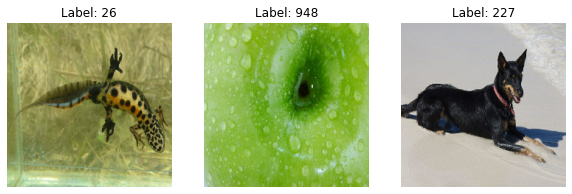

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(x_test[i].numpy())  # Convert tensor to numpy array for plotting
    plt.title(f'Label: {y_test[i].numpy()}')  # Convert label to numpy for display
    plt.axis('off')
plt.show()

In [11]:
from tensorflow.keras.applications import MobileNetV2

model = MobileNetV2(weights='imagenet', input_shape=(224, 224, 3))
#model.summary()


In [12]:
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
compiled_model = model.compile(loss='sparse_categorical_crossentropy', optimizer = opt, metrics=["accuracy"])

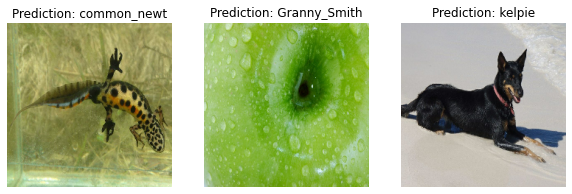

In [13]:

plt.figure(figsize=(10, 5))
num_images = 3;
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    
    
    # image preprocessing
    image_to_predict = tf.expand_dims(x_test[i], axis=0)  # Add extra dimention
    image_to_predict = tf.image.resize(image_to_predict, (224, 224))  # make 244x244
    image_to_predict = tf.keras.applications.mobilenet_v3.preprocess_input(image_to_predict)  # normalize to 1-0
    plt.imshow(image_to_predict.numpy()[0])  # display
    
    # Make prediction
    prediction = model.predict(image_to_predict)

    #predicted_label = np.argmax(prediction)
    
    predicted_label = tf.keras.applications.mobilenet_v3.decode_predictions(prediction, top=1)[0][0][1]
    
    
    #plt.title(f'{predicted_label}')  # Convert label to numpy for display
    plt.title(f'Prediction: {predicted_label}')  # Convert label to numpy for display
    plt.axis('off')
plt.show()

In [14]:
score = model.evaluate(x_test, y_test,  verbose=0, batch_size=32)
print("test loss, test acc:", score)



test loss, test acc: [1.1321816444396973, 0.75]


## 3. Quantization
In order to compile the trained model for deployment on a DPU platform, we must first quantize it. Here we will use the `vitis_quantize` module to convert the floating point model into an INT8 quantized representation. 

In [15]:
from tensorflow_model_optimization.quantization.keras import vitis_quantize

**Quantize model**

By default the `quantize_model` function converts the weights, activations and inputs into 8-bit wide numbers. We can specify different values and configurations using `weight_bit`, `activation_bit` and other parameters. 

In [16]:
quantizer = vitis_quantize.VitisQuantizer(model)
quantized_model = quantizer.quantize_model(calib_dataset = x_test, weight_bit=8, activation_bit=8)

[VAI INFO] Update activation_bit: 8
[VAI INFO] Update weight_bit: 8
[VAI INFO] Start CrossLayerEqualization...
10/10 [==============================] - 4s 498ms/step
[VAI INFO] CrossLayerEqualization Done.
[VAI INFO] Start Quantize Calibration...
1/1 [==============================] - 20s 20s/step
[VAI INFO] Quantize Calibration Done.
[VAI INFO] Start Post-Quant Model Refinement...
[VAI INFO] Start Quantize Position Ajustment...
[VAI INFO] Quantize Position Ajustment Done.
[VAI INFO] Post-Quant Model Refninement Done.
[VAI INFO] Start Model Finalization...
[VAI INFO] Model Finalization Done.
[VAI INFO] Quantization Finished.


**Evaluate quantized model**

In order to evaluate the quantized model, it needs to be re-compiled with the desired loss and evaluation metrics, such as accuracy. Since we are using 8-bit quantization we do not lose much performance, if at all.

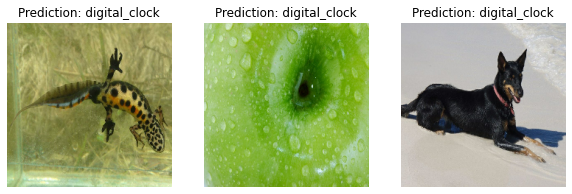

In [17]:

plt.figure(figsize=(10, 5))
num_images = 3;
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    
    
    # image preprocessing
    image_to_predict = tf.expand_dims(x_test[i], axis=0)  # Add extra dimention
    image_to_predict = tf.image.resize(image_to_predict, (224, 224))  # make 244x244
    image_to_predict = tf.keras.applications.mobilenet_v3.preprocess_input(image_to_predict)  # normalize to 1-0
    plt.imshow(image_to_predict.numpy()[0])  # display
    
    # Make prediction
    prediction = quantized_model.predict(image_to_predict)

    #predicted_label = np.argmax(prediction)
    
    predicted_label = tf.keras.applications.mobilenet_v3.decode_predictions(prediction, top=1)[0][0][1]
    
    
    #plt.title(f'{predicted_label}')  # Convert label to numpy for display
    plt.title(f'Prediction: {predicted_label}')  # Convert label to numpy for display
    plt.axis('off')
plt.show()

In [ ]:
quantized_model.compile(loss='sparse_categorical_crossentropy', metrics=["accuracy"])

score = quantized_model.evaluate(x_test, y_test,  verbose=1, batch_size=32)
print(score)

**Save quantized model**

Once we are happy with the performance of the quantized model, we can save it as a .h5 file, simply using the `save` method.

In [ ]:
quantized_model.save('tf2_mnist_classifier_quantized.h5')

## 4. Compilation

For this final step we use the Vitis AI compiler `vai_c_tensorflow2` and pass the quantized model as a parameter. In this example we are compiling the DPU model targeting the KV260 board, however to target a different board you will just have to point the compiler to the right `arch.json` file. 

For example, for the ZCU104 you would pass

`--arch /opt/vitis_ai/compiler/arch/DPUCZDX8G/ZCU104/arch.json`

and for Ultra96, we can pass the custom arch.json in this repository

`--arch ./arch.json`

In [ ]:
!vai_c_tensorflow2 \
    --model /workspace/DPU-PYNQ-converters/Conversion-Scripts/mobilenet_v3_model.h5 \
    --arch /opt/vitis_ai/compiler/arch/DPUCZDX8G/KV260/arch.json \
    --output_dir . \
    --net_name mobilenet_v3

----

Copyright (C) 2021 Xilinx, Inc

SPDX-License-Identifier: Apache-2.0 License

----

----